In [1]:
import torch
from PIL import Image
import numpy
import sys
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from vit_rollout import VITAttentionRollout
from vit_grad_rollout import VITAttentionGradRollout
from vit_flow import VITAttentionFlow
import requests
import torch.nn.functional as F
import torch.nn as nn

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE}")

IMAGE_SIZE = 224
DISCARD_RATIO = 0.9

def preprocess_image(image_path, transform):
    img = Image.open(image_path)
    input_tensor = transform(img).unsqueeze(0)
    return input_tensor.to(DEVICE)

def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

model = torch.hub.load('facebookresearch/deit:main', 
        'deit_tiny_patch16_224', pretrained=True)
model.eval()
model.to(DEVICE)

Using cpu


Using cache found in /Users/francoisreynal/.cache/torch/hub/facebookresearch_deit_main
/Users/francoisreynal/env_ea_map/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=768, out_features=192, bias=True)
        (drop2): Dropout(p=0.0, inplace=Fals

### Important fonctions

In [3]:
category_index =  264#@param {type:"integer"}
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
classes = {int(key): value for (key, value) in requests.get(LABELS_URL).json().items()}


In [4]:

def get_mask_strategy(input_tensor, strategy):
    if strategy == "grad_attention_rollout" and category_index < 0:
        raise Exception("Category index is mandatory when using Gradient Attention Rollout")

    elif strategy == "grad_attention_rollout" and category_index > 0:
        grad_rollout = VITAttentionGradRollout(model, discard_ratio=DISCARD_RATIO)
        mask = grad_rollout(input_tensor, category_index)
        name = "grad_rollout_{}_{:.3f}_{}.png".format(category_index,
            DISCARD_RATIO, "mean")

    elif strategy == "attention_rollout":
        attention_rollout = VITAttentionRollout(model, discard_ratio=DISCARD_RATIO)
        mask = attention_rollout(input_tensor)
        name = "attention_rollout_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
        
    elif strategy == "attention_flow":
        attention_flow = VITAttentionFlow(model, discard_ratio=DISCARD_RATIO)
        mask = attention_flow(input_tensor)
        name = "attention_flow_{:.3f}_{}.png".format(DISCARD_RATIO, "mean")
    return mask

In [5]:
def reshape_mask(mask):
    if mask.shape[0] == 196: #attention flow input
        mask=torch.flatten(torch.tensor(mask)) 
        mask=mask.reshape(14,14)
        mask = mask.float()
        mask=mask.detach().numpy()

    mask=cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
    #print(mask.shape)
    return mask

### Deciding which threshold to use for the mask

1


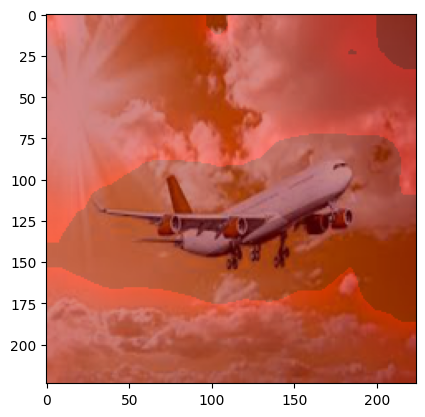

2


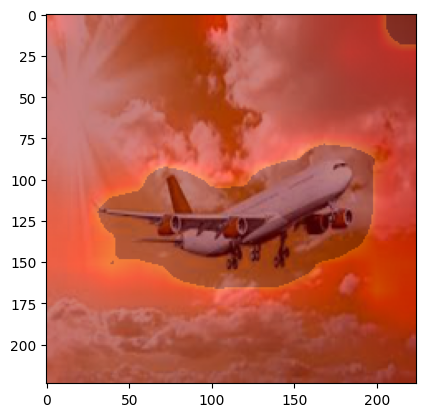

3


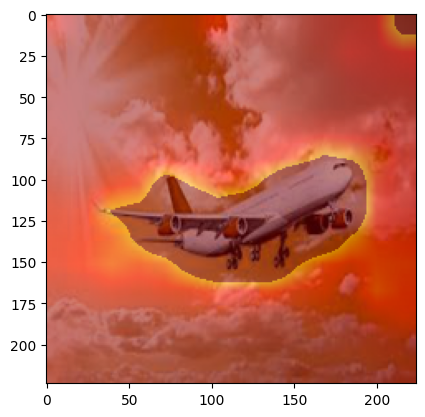

4


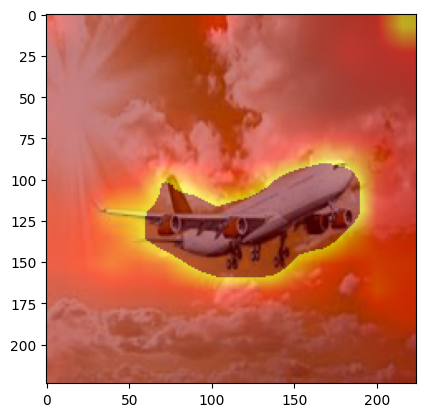

5


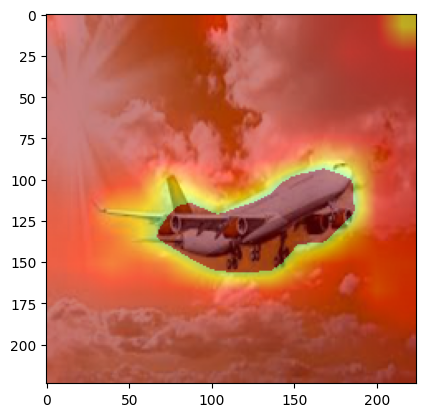

6


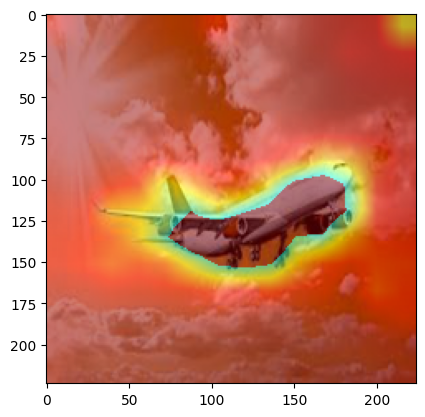

7


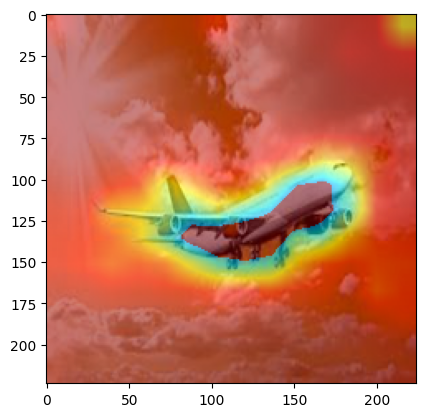

In [6]:
import copy 

def decide_which_threshold(mask, img):
    for i in range(1,8,1):
        print(i)
        new_mask = copy.deepcopy(mask)
        new_mask[mask> i/10] = 0
        plt.imshow(new_mask)

        np_img = np.array(img)[:, :, ::-1]
        image_and_mask = show_mask_on_image(np_img, new_mask)

        plt.imshow(image_and_mask)
        plt.show()

img = Image.open("examples/plane.png")
input_tensor  = preprocess_image("examples/plane.png", transform)
rollout_strategy = "attention_rollout" #["attention_rollout", "grad_attention_rollout"]
mask = get_mask_strategy(input_tensor, rollout_strategy)
mask = reshape_mask(mask)
decide_which_threshold(mask, img) # chosen threshold is 0.2

### Attacks on the model

In [7]:
def get_best_prediction(scores):
    scores=scores.cpu()
    h_x = F.softmax(scores, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.numpy()
    idx = idx.numpy()
    return  classes[idx[0]]#, probs[idx[0]]  #get the highest score

# value of threshold of 0 and out_area == True -> no attack
# value of threshold of 1 and out_area == False -> no attack
def fgsm_attack(image, mask, epsilon, data_grad, out_area_interest, threshold = 0.2):
    
    grad_sign = torch.sign(data_grad)

    new_mask = copy.deepcopy(mask)
    if out_area_interest:
        number_pix_attacked = np.sum(mask < threshold)
        new_mask[mask > threshold] = 0
    else:
        number_pix_attacked = np.sum(mask > threshold)
        new_mask[mask < threshold] = 0
    
    new_mask = torch.tensor(new_mask).to(DEVICE)

    perturbed_image = image + epsilon * grad_sign * new_mask

    #perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image, number_pix_attacked

In [8]:
def multiple_attacks(image, mask, idx, epsilon, out_area_interest, thresold=50):
    attack_number = 0

    img_tensor = image.requires_grad_(True)  # Ensure img_tensor is a leaf variable
    assumption = True
    scores = model(img_tensor)
    my_pred = get_best_prediction(scores)
    #print("image prediction", my_pred)
    target = torch.tensor([idx]).to(DEVICE).long()
    criterion = nn.CrossEntropyLoss()
    loss = criterion(scores, target)
    loss.backward()  # Backpropagate the loss
    #loss.backward(retain_graph=True)  # Backpropagate the loss

    data_grad = img_tensor.grad.data
    

    while attack_number < thresold and assumption:
        
        model.zero_grad()
        img_tensor, number_pix_attacked = fgsm_attack(img_tensor, mask, epsilon, data_grad, out_area_interest)
        attack_number += 1
        criterion = nn.CrossEntropyLoss()
        img_tensor = img_tensor.requires_grad_(True)  # Ensure img_tensor is a leaf variable
        target = torch.tensor([idx]).to(DEVICE).long()
        scores = model(img_tensor)
        loss = criterion(scores, target)
        loss.backward()  # Backpropagate the loss
        # loss.backward(retain_graph=True)  # Backpropagate the loss

        #data_grad = img_tensor.grad.data
        new_best_prediction = get_best_prediction(scores)
        #print(new_best_prediction)
        if new_best_prediction == my_pred : #['n02692877', 'airship']
            assumption = True
        else:
            assumption = False

    #print("Class changed after", attack_number, "attacks.")
    #print( new_best_prediction)

    # Help function to get the loss

    def norm_L1(tensor_original, tensor_modified, number_pix_attacked):
        diff = abs(tensor_modified - tensor_original)
        #print(tensor_original.shape)
        #print(tensor_modified.shape)
        diff = torch.mean(diff, dim=1)
        #print(diff.shape)
        sum_of_means = torch.sum(diff)
        return sum_of_means / number_pix_attacked

    norml1 = norm_L1(image, img_tensor, number_pix_attacked)

    # Transforming back to an image
    mean = torch.Tensor([0.5,0.5,0.5]).view(-1,1,1)
    std = torch.Tensor([0.5,0.5,0.5]).view(-1,1,1)
    x_img = (img_tensor * std + mean).squeeze(0)
    modified_image = np.transpose(x_img.detach().numpy(), [1,2,0])


    # Plotting the result of the attack

    # fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    # ax1.set_title('Original')
    # ax2.set_title('Attacked')

    # _ = ax1.imshow(img)
    # _ = ax2.imshow(modified_image)


    img_tensor.zero_()
    img_tensor = None
    del img_tensor
    
    scores.zero_()
    scores = None

    target.zero_()
    target = None

    mean.zero_()
    mean = None

    loss.zero_()
    loss = None

    std.zero_()
    std = None
    x_img.zero_()
    x_img = None

    modified_image = None


   

    return attack_number, new_best_prediction[1], norml1

In [9]:
# Help function to get the loss

def norm_L1(tensor_original, tensor_modified, number_pix_attacked):
    diff = abs(tensor_modified - tensor_original)
    #print(tensor_original.shape)
    #print(tensor_modified.shape)
    diff = torch.mean(diff, dim=1)
    #print(diff.shape)
    sum_of_means = torch.sum(diff)
    return sum_of_means / number_pix_attacked

In [10]:
# Help fonciton to get the paths
import os
def get_files_in_folder(folder_path):
    file_paths = []
    if os.path.isdir(folder_path):
        # Iterate through all files in the directory
        for file_name in os.listdir(folder_path):
            # Construct the full path to the file
            file_path = os.path.join(folder_path, file_name)
            # Check if the path points to a file (not a directory)
            if os.path.isfile(file_path):
                file_paths.append(file_path)
    return file_paths

### Pipeline

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(tensor(0.4812, grad_fn=<DivBackward0>), 1)

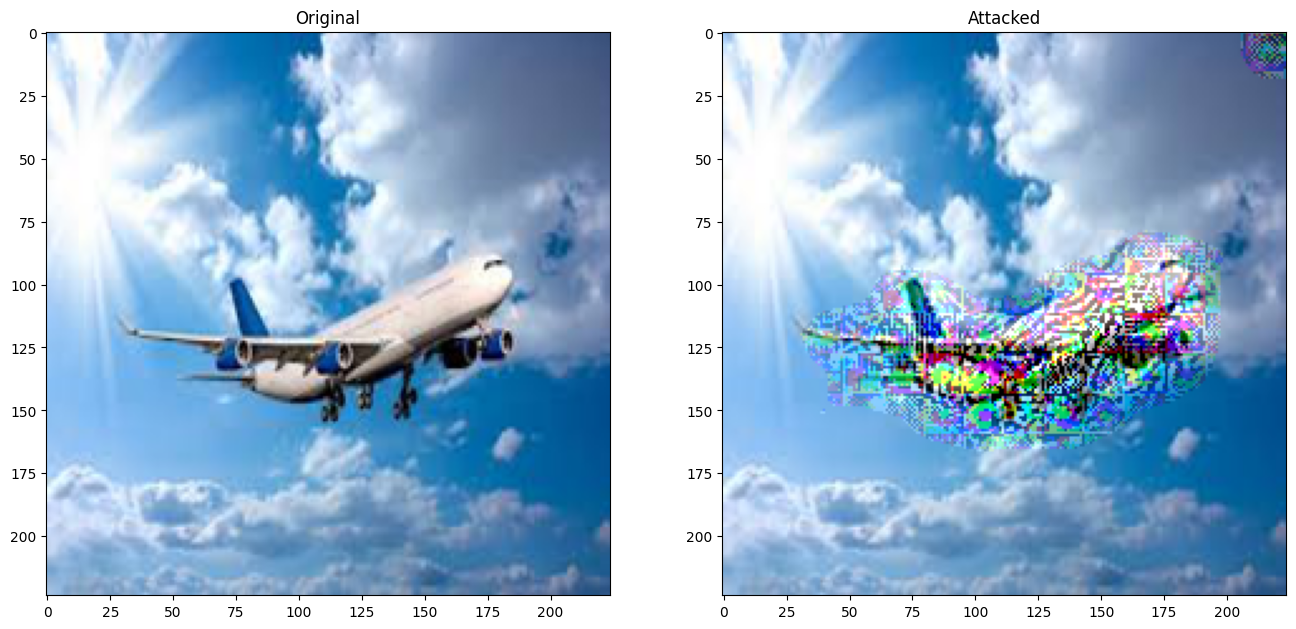

In [43]:
img = Image.open("examples/plane.png")
input_tensor  = preprocess_image("examples/plane.png", transform)
rollout_strategy = "attention_rollout" #["attention_rollout", "grad_attention_rollout"]
eps = 1
idx_target = 265

# Following boolean controls whether the attack will be on the rest of image or on the important part of image
boolean_out_area_of_interest = False


mask = get_mask_strategy(input_tensor, rollout_strategy)
mask = reshape_mask(mask)

attack_number, new_best_prediction, norml1 =multiple_attacks(input_tensor,mask,idx_target, eps, boolean_out_area_of_interest)
norml1, attack_number

### For all the images: 

#### if mask is not already computed:

In [11]:
folder_path = 'images'
file_paths_list = get_files_in_folder(folder_path)

rollout_strategy = "attention_rollout" #["attention_rollout", "grad_attention_rollout"]
eps = 0.05
idx_target = 265

n_attacks_outside = []
l1norms_outside = []
n_attacks_inside = []
l1norms_inside = []

counter = 1

# 34, 107, 118, 126, 141, 223

with open("results_attacks.txt", "w") as f_attacks:
    for path_image in np.sort(file_paths_list[counter-1:])[202:]:
        if counter in {34, 107, 118, 126, 141, 223}:
            counter+=1
            continue

        img = Image.open(path_image)
        input_tensor  = preprocess_image(path_image, transform)
        
        #print(input_tensor.shape)

        mask = get_mask_strategy(input_tensor, rollout_strategy)
        mask = reshape_mask(mask)
        #print(mask.shape)
        attack_number_out, _ , norml1_out = multiple_attacks(input_tensor,mask,idx_target, eps, out_area_interest=True)
        #attack_number_out, _ , norml1_out = 0,0,0

        img.close()
        img = 0
        input_tensor = None
        del input_tensor
        
        img = Image.open(path_image)
        input_tensor  = preprocess_image(path_image, transform)
        attack_number_in, _ , norml1_in =multiple_attacks(input_tensor,mask,idx_target, eps, out_area_interest=False)
        #attack_number_in, _ , norml1_in = 0,0,0
        
        img.close()
        img = 0
        
        input_tensor = None
        del input_tensor

        print(f"image nb {counter}", attack_number_out, attack_number_in)

        # Write attack results to file
        f_attacks.write(f"{attack_number_out},{attack_number_in},{norml1_out},{norml1_in}\n")
        counter+=1

        n_attacks_outside.append(attack_number_out)
        n_attacks_inside.append(attack_number_in)
        l1norms_outside.append(norml1_out)
        l1norms_inside.append(norml1_in)

image nb 203 31 1
image nb 204 3 3
image nb 205 50 50
image nb 206 16 3
image nb 207 2 1
image nb 208 50 50
image nb 209 50 50
image nb 210 2 3
image nb 211 50 50
image nb 212 50 2
image nb 213 50 50
image nb 214 50 50
image nb 215 50 50
image nb 216 50 50
image nb 217 50 4
image nb 218 50 50
image nb 219 1 8
image nb 220 2 5
image nb 221 18 50
image nb 222 2 5
image nb 224 5 4
image nb 225 50 3
image nb 226 50 50
image nb 227 50 50
image nb 228 1 2
image nb 229 2 50
image nb 230 50 50
image nb 231 2 2
image nb 232 2 1
image nb 233 50 50
image nb 234 50 4
image nb 235 50 50
image nb 236 50 1
image nb 237 2 1
image nb 238 50 2
image nb 239 1 1
image nb 240 3 7
image nb 241 19 50
image nb 242 50 1
image nb 243 50 50
image nb 244 27 2
image nb 245 50 50
image nb 246 4 11
image nb 247 50 50
image nb 248 5 6
image nb 249 50 9
image nb 250 50 50


#### If mask is already computed :


In [12]:
import torch

file_path = 'attention_grad_rollout.txt' 
arrays = []

with open(file_path, 'r') as file:
    for line in file:
        line = line.strip()
        
        if not line:
            arrays.append(np.array(numbers))
            continue
        
        numbers = line.split(',')
        numbers = [float(num) for num in numbers]
        arrays.append(np.array(numbers))

print(np.shape(arrays))
print(arrays)

(250, 196)
[array([0.077, 0.008, 0.022, 0.009, 0.029, 0.009, 0.016, 0.01 , 0.026,
       0.002, 0.002, 0.017, 0.014, 0.111, 0.025, 0.031, 0.03 , 0.012,
       0.012, 0.058, 0.004, 0.017, 0.009, 0.047, 0.008, 0.003, 0.009,
       0.015, 0.002, 0.008, 0.013, 0.002, 0.021, 0.008, 0.019, 0.005,
       0.022, 0.006, 0.007, 0.005, 0.009, 0.029, 0.015, 0.016, 0.01 ,
       0.04 , 0.005, 0.007, 0.011, 0.004, 0.003, 0.008, 0.003, 0.002,
       0.012, 0.007, 0.002, 0.019, 0.003, 0.039, 0.218, 0.13 , 0.069,
       0.138, 0.118, 0.395, 0.278, 0.963, 0.022, 0.013, 0.029, 0.002,
       0.004, 0.435, 1.   , 0.516, 0.363, 0.67 , 0.678, 0.706, 0.474,
       0.024, 0.007, 0.016, 0.077, 0.03 , 0.001, 0.605, 0.213, 0.037,
       0.051, 0.009, 0.045, 0.016, 0.072, 0.008, 0.056, 0.03 , 0.005,
       0.005, 0.003, 0.054, 0.028, 0.005, 0.004, 0.018, 0.007, 0.002,
       0.002, 0.001, 0.003, 0.003, 0.002, 0.001, 0.001, 0.003, 0.002,
       0.006, 0.004, 0.009, 0.001, 0.002, 0.   , 0.004, 0.001, 0.003,
       0

In [13]:
folder_path = 'images'
file_paths_list = get_files_in_folder(folder_path)

rollout_strategy = "attention_rollout" #["attention_rollout", "grad_attention_rollout"]
eps = 0.05
idx_target = 265

n_attacks_outside = []
l1norms_outside = []
n_attacks_inside = []
l1norms_inside = []

counter = 1

# 34, 107, 118, 126, 141, 223

with open("results_attacks.txt", "w") as f_attacks:
    for path_image in np.sort(file_paths_list[:])[counter-1:]:
        if counter in {34, 107, 118, 126, 141, 223}:
            counter+=1
            continue

        img = Image.open(path_image)
        input_tensor  = preprocess_image(path_image, transform)
        
        #print(input_tensor.shape)
        mask = arrays[counter-1]
        mask = reshape_mask(mask)
        #print(mask.shape)
        attack_number_out, _ , norml1_out = multiple_attacks(input_tensor,mask,idx_target, eps, out_area_interest=True)
        #attack_number_out, _ , norml1_out = 0,0,0

        img.close()
        img = 0
        input_tensor = None
        del input_tensor
        
        img = Image.open(path_image)
        input_tensor  = preprocess_image(path_image, transform)
        attack_number_in, _ , norml1_in =multiple_attacks(input_tensor,mask,idx_target, eps, out_area_interest=False)
        #attack_number_in, _ , norml1_in = 0,0,0
        
        img.close()
        img = 0
        
        input_tensor = None
        del input_tensor

        print(f"image nb {counter}", attack_number_out, attack_number_in)

        # Write attack results to file
        f_attacks.write(f"{attack_number_out},{attack_number_in},{norml1_out},{norml1_in}\n")
        counter+=1

        n_attacks_outside.append(attack_number_out)
        n_attacks_inside.append(attack_number_in)
        l1norms_outside.append(norml1_out)
        l1norms_inside.append(norml1_in)

image nb 100 21 5
image nb 101 3 4
image nb 102 3 8
image nb 103 50 50
image nb 104 3 1
image nb 105 1 1
image nb 106 1 1
image nb 108 1 50
image nb 109 50 50
image nb 110 1 1
image nb 111 50 50
image nb 112 2 1
image nb 113 50 50
image nb 114 50 50
image nb 115 50 50
image nb 116 50 50
image nb 117 50 50
image nb 119 4 4
image nb 120 50 50
image nb 121 1 1
image nb 122 50 50
image nb 123 50 50
image nb 124 50 2
image nb 125 1 1
image nb 127 50 3
image nb 128 50 50
image nb 129 1 1
image nb 130 11 50
image nb 131 50 50
image nb 132 3 2
image nb 133 50 50
image nb 134 4 3
image nb 135 50 50
image nb 136 1 1
image nb 137 50 11
image nb 138 50 50
image nb 139 50 50
image nb 140 8 7
image nb 142 50 50
image nb 143 50 50
image nb 144 50 50
image nb 145 50 50
image nb 146 1 2
image nb 147 1 1
image nb 148 1 1
image nb 149 12 2
image nb 150 50 50
image nb 151 1 4


KeyboardInterrupt: 


--------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------